# Benchmarking

# Using QPCA class

In [1]:
from QPCA.decomposition.Qpca import QPCA
import numpy as np
import pandas as pd
from QPCA.preprocessingUtilities.preprocessing import generate_matrix
import time
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
from qiskit_aer import AerSimulator, Aer
from qiskit.primitives import BackendSampler

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    min_=(np.abs(array - value)).min()
    return array[idx],min_

In [3]:
real_data = False
noisy_experiments = False
real_hw = False
threshold = 0.1
matrix_dimension = 2
resolutions = [4]
shots_numbers = [1000]#[100, 500, 1500, 10000, 100000, 500000, 1000000]

if matrix_dimension == 2:
    seed = [1235, 1235, 19, 87, 16, 856, 100, 4444, 107, 500]
elif matrix_dimension == 4:
    seed = [1235, 1235, 543, 4747, 6734, 543, 1000, 1500, 900, 3500]

if real_hw or noisy_experiments:
    service = QiskitRuntimeService(channel="ibm_cloud", token="", instance="")
    old_backend = service.get_backend('ibm_algiers')
    if noisy_experiments:
        backend = BackendSampler(AerSimulator.from_backend(old_backend))
        backend.set_transpile_options(seed_transpiler=42)
    else:
        options = Options(transpilation={'seed_transpiler': 42})
        backend = Sampler(old_backend, options=options)
else:
    backend = BackendSampler(Aer.get_backend('qasm_simulator'))
    backend.set_transpile_options(seed_transpiler=42)

if real_data:
    df = pd.read_csv("Dataset/covariance_matrix")

Matrix:
 [[1.5 0.5]
 [0.5 1.5]]

eigenvalue: 1.0 - eigenvector: [-0.707  0.707]
eigenvalue: 2.0 - eigenvector: [0.707 0.707]


Resolution:  4




You chose 4 qubits of resolution. This corresponds to an accuracy of 0.0625, 
if you know that some eigenvalues are smaller or closer to each other than 0.0625, please add resolution qubits to get better estimates.
You are performing tomography with less than 10.000 measures. 
Note that to obtain accurate estimates, it is recommended to carry out at least 10.000 measurements.


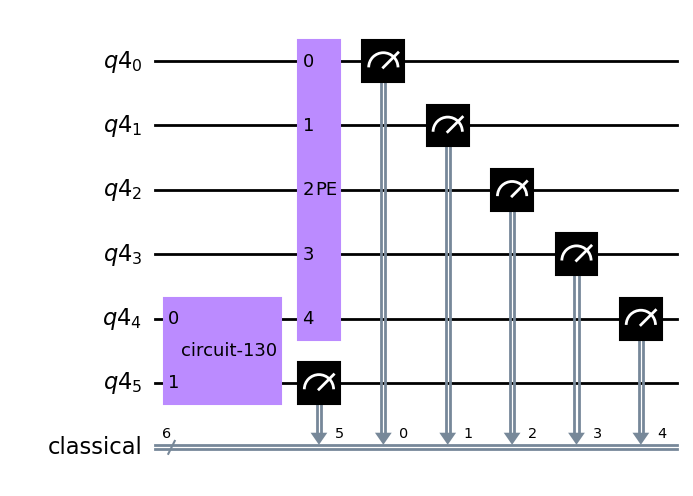

AE Job status is DONE      
SE Job status is DONE       
total runtime:  61.5612154006958
reconstructed_eigenvalues: [0.6875 0.3125]
reconstructed_eigenvectors: [[ 0.66914752  0.71570637]
 [-0.55933496  0.75350844]]


You set an absolute tolerance of 0.001. If some output eigenvalues are not the expected ones, it is recommended to increase the absolute tolerance to cut away the noisy eigenvalues.


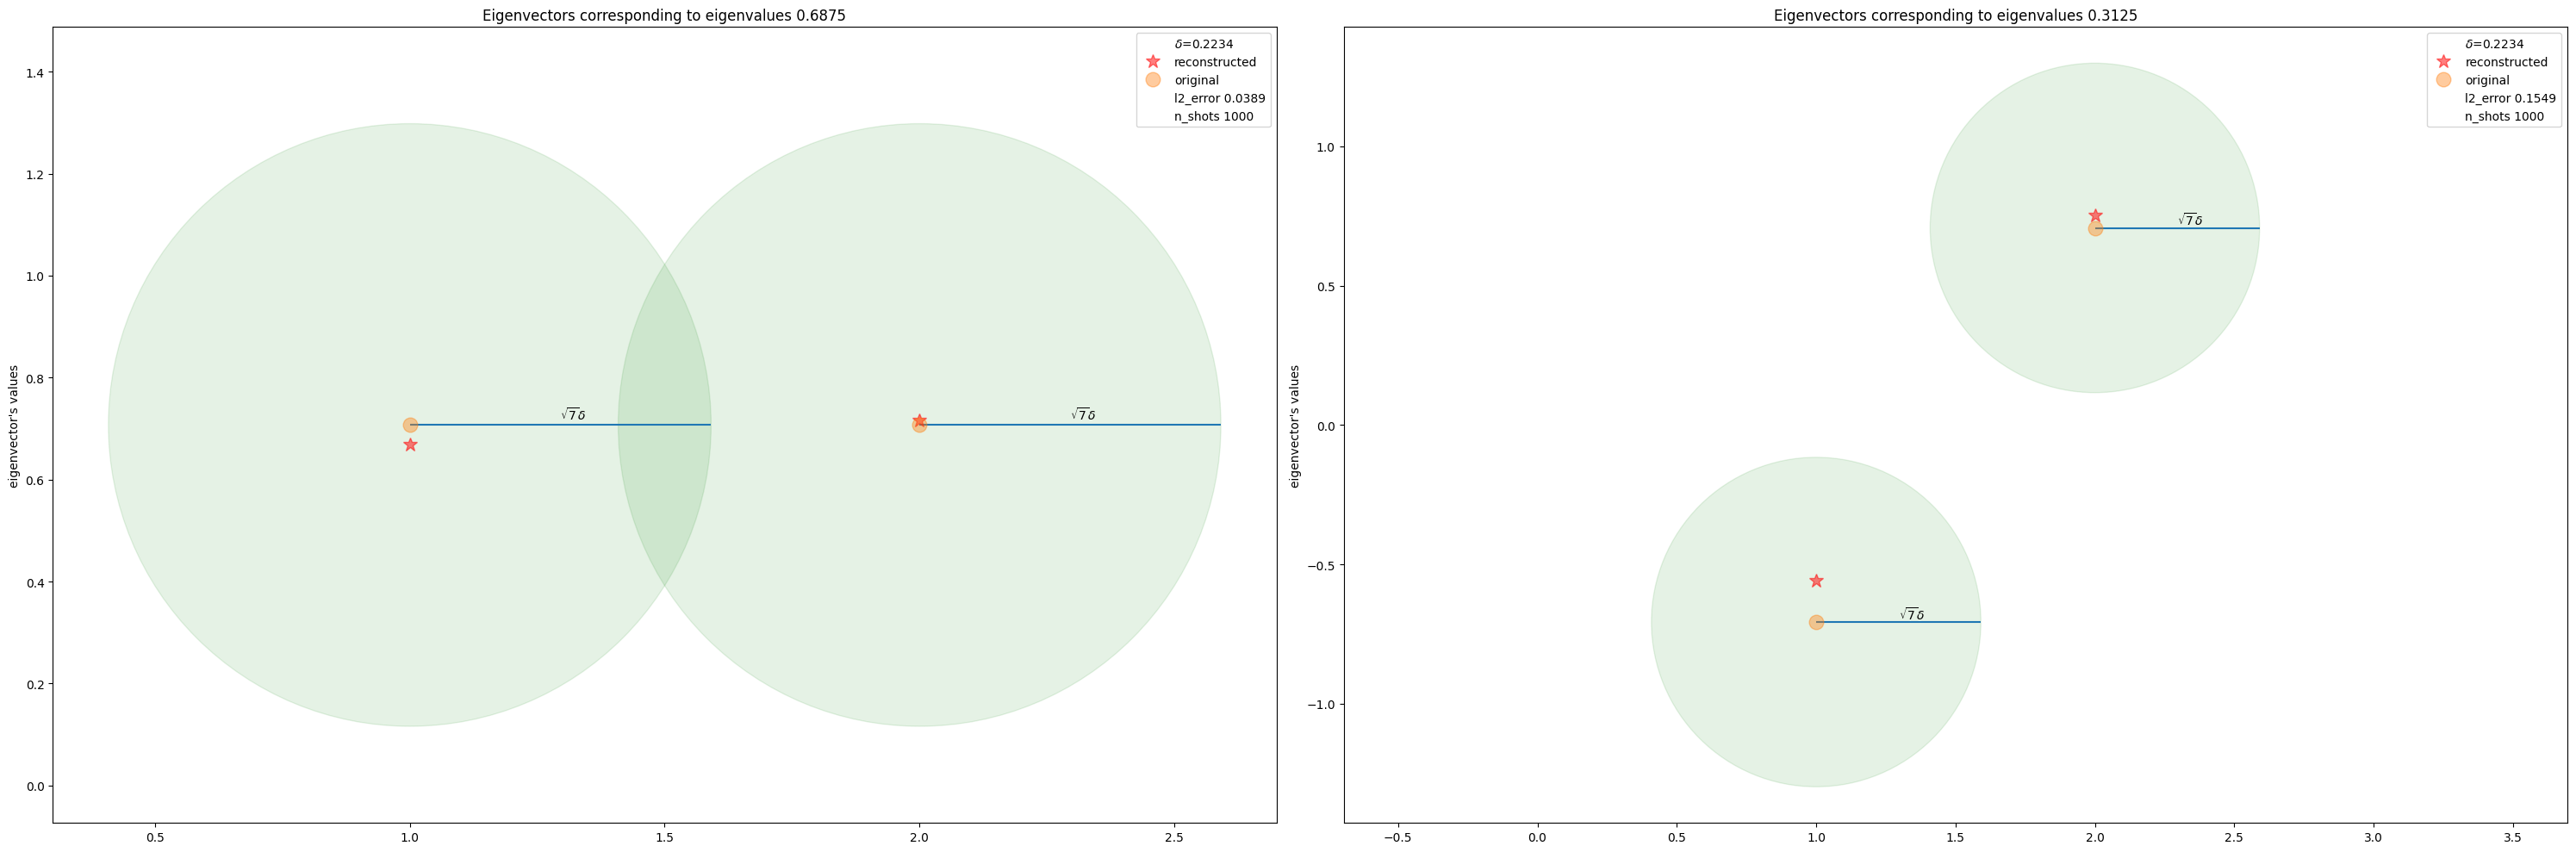

held eigenvalues after benchmark cleaning:  [0.6875, 0.3125]
corresponding_eigenvectors:  [[ 0.66914752  0.71570637]
 [-0.55933496  0.75350844]]
Matrix:
 [[1.89 1.39]
 [1.39 1.12]]

eigenvalue: 0.0608643763272152 - eigenvector: [-0.605  0.796]
eigenvalue: 2.9531490884581273 - eigenvector: [0.796 0.605]


Resolution:  4




You chose 4 qubits of resolution. This corresponds to an accuracy of 0.0625, 
if you know that some eigenvalues are smaller or closer to each other than 0.0625, please add resolution qubits to get better estimates.
You are performing tomography with less than 10.000 measures. 
Note that to obtain accurate estimates, it is recommended to carry out at least 10.000 measurements.


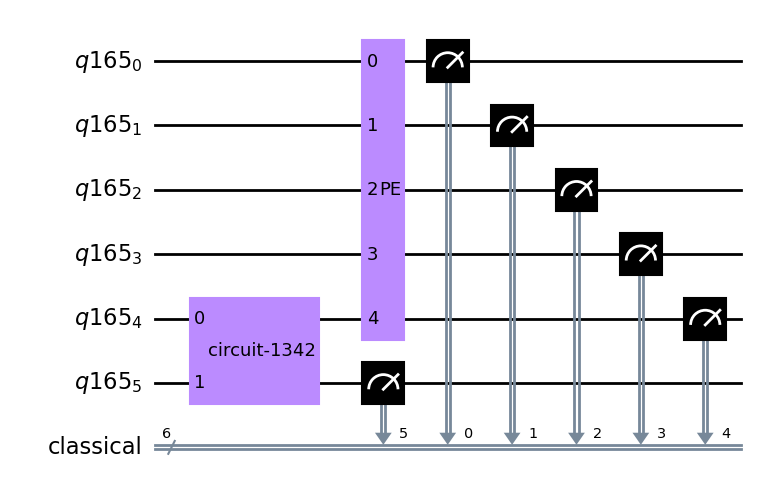

AE Job status is DONE      
SE Job status is DONE       
total runtime:  61.24859929084778
reconstructed_eigenvalues: [0.5625 0.3125]
reconstructed_eigenvectors: [[0.84089642 0.59460356]
 [0.75983569 0.75983569]]


You set an absolute tolerance of 0.001. If some output eigenvalues are not the expected ones, it is recommended to increase the absolute tolerance to cut away the noisy eigenvalues.


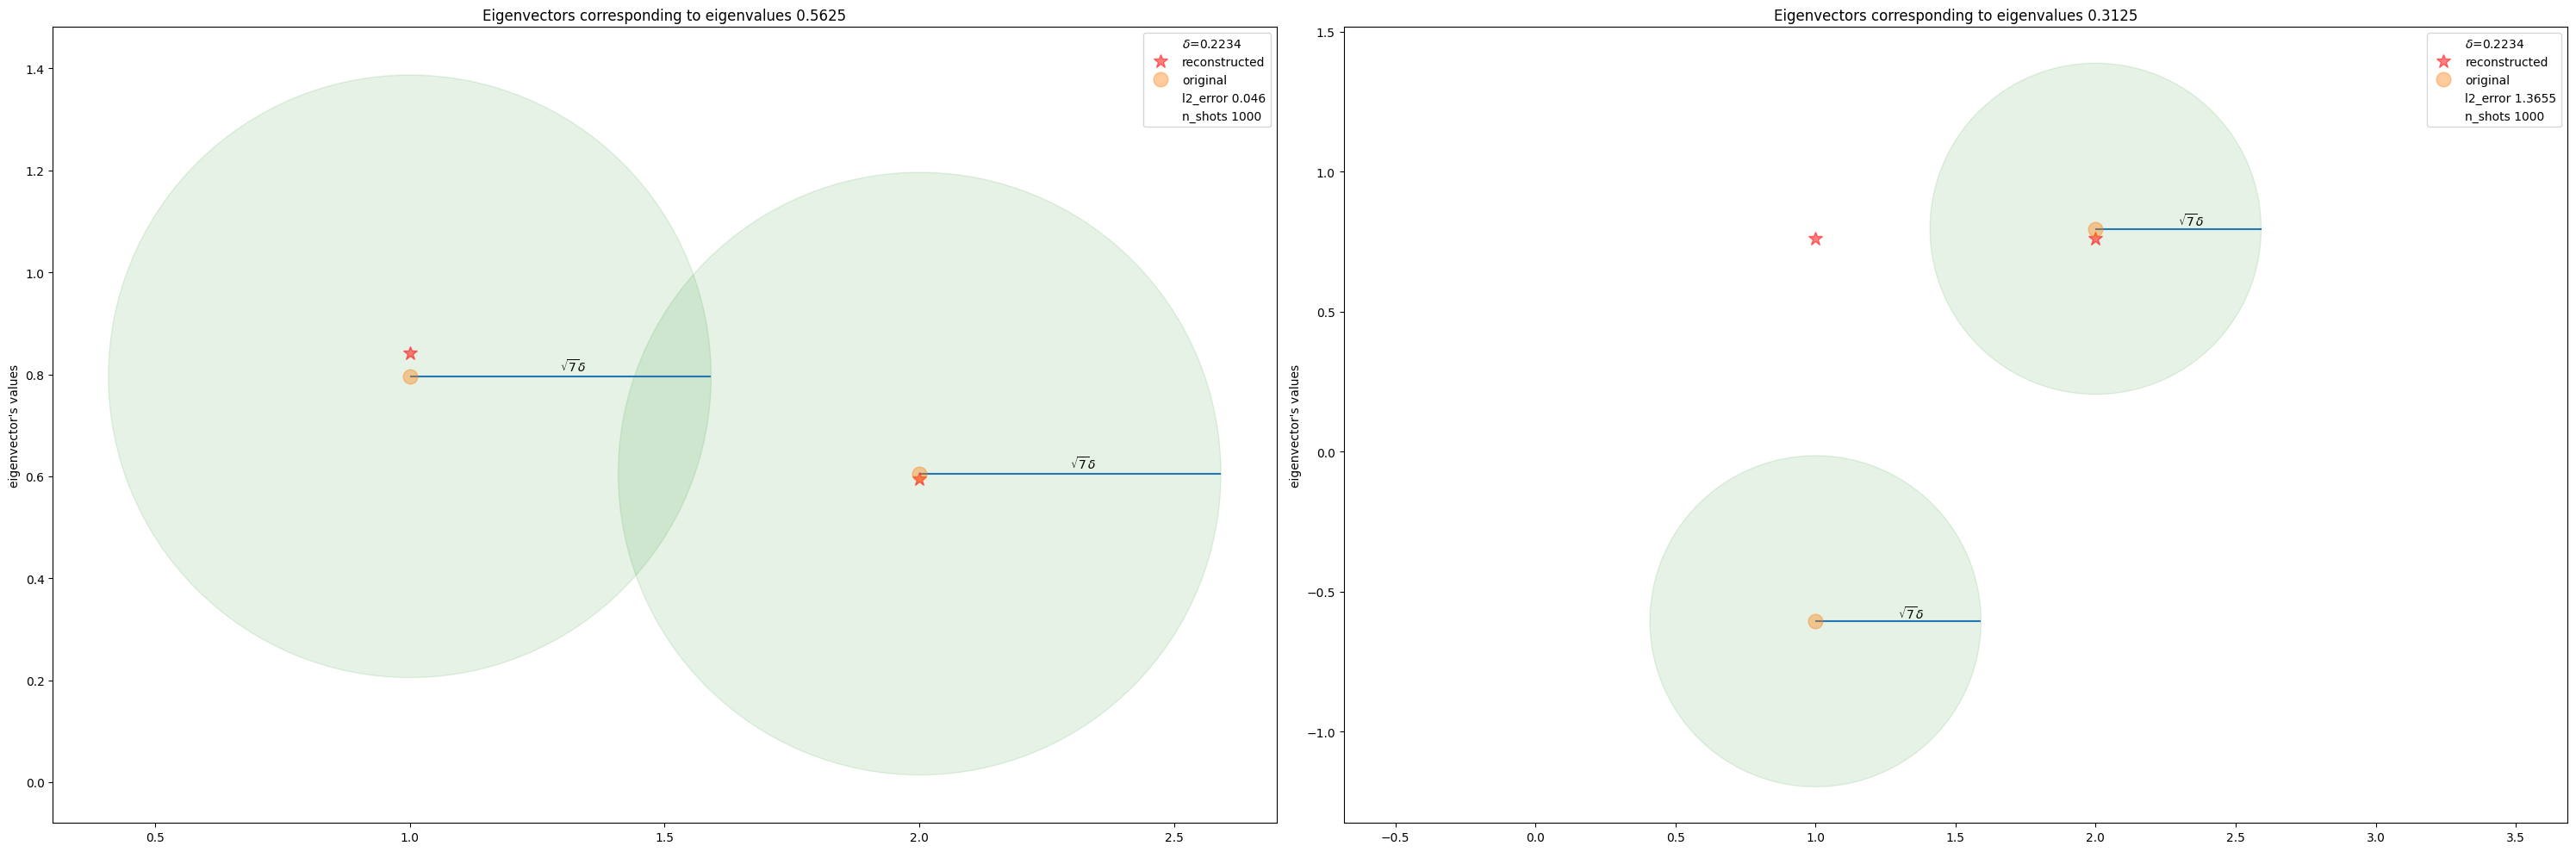

held eigenvalues after benchmark cleaning:  [0.5625, 0.3125]
corresponding_eigenvectors:  [[0.84089642 0.59460356]
 [0.75983569 0.75983569]]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [4]:
"""
This code performs benchmarking on a given input matrix using the QuPCA algorithm.
It iterates over different seeds, number of shots and resolutions to generate input matrices and perform benchmarking.
The benchmarking results are stored in a DataFrame called 'output'.
"""

for e in range(10):
    if real_data == False:
        # Generate input matrix
        if e == 0:
            re_paper = True
        else:
            re_paper = False
        input_matrix = generate_matrix(matrix_dimension=matrix_dimension, replicate_paper=re_paper, seed=seed[e])
    else:
        # Use real data as input matrix
        j = e + (matrix_dimension - 1)
        input_matrix = df.iloc[e:j+1, e:j+1].to_numpy()
    
    for resolution in resolutions:
        start_time_fit = time.time()
        # Fit the input matrix using QPCA
        qpca = QPCA().fit(input_matrix, resolution=resolution, optimized_qram=True)
        end_time_fit = time.time()
        total_time_fit = end_time_fit - start_time_fit
        
        eigenValues, eigenVectors = np.linalg.eig(qpca.input_matrix)
        idx = eigenValues.argsort()[::-1]   
        original_eigenValues = eigenValues[idx]
        original_eigenVectors = eigenVectors[:, idx]
        basic_dict = {original_eigenValues[o]: o for o in range(len(original_eigenValues))}
        
        error_list = []
        delta_list = []
        shots_dict = {}
        
        print('\n')
        print('\033[1m' + 'Resolution: ', resolution)
        print('\n')
        
        for s in shots_numbers:
            dict_ = {}
            number_of_errors = np.zeros(len(input_matrix))
            number_of_errors[:] = np.nan

            reconstructed_ev = np.empty((len(input_matrix), len(input_matrix)))
            reconstructed_ev[:] = np.nan

            start_time_reconstruction = time.time()
            # Perform eigenvectors reconstruction using QPCA
            eigenvalues, eigenvectors, _, _ = qpca.eigenvectors_reconstruction(n_shots=s, n_repetitions=1, backend=backend, eigenvalue_threshold=threshold)
            end_time_reconstruction = time.time()
            total_time_reconstruction = end_time_reconstruction - start_time_reconstruction

            total_runtime = total_time_fit + total_time_reconstruction

            print('total runtime: ', total_runtime)

            k = eigenvalues.argsort()[::-1]   
            eigenvalues = eigenvalues[k]
            eigenvectors = eigenvectors[:, k]

            eigenvectors = np.array([eigenvectors[:, i] for i in range(len(eigenvalues))])

            print('reconstructed_eigenvalues:', eigenvalues)
            print('reconstructed_eigenvectors:', eigenvectors)

            eigenvalues_to_keep = []
            try:
                # Perform spectral benchmarking
                results = qpca.spectral_benchmarking(eigenvector_benchmarking=True, sign_benchmarking=False,
                                                    eigenvalues_benchmarching=False, print_distances=True,
                                                    only_first_eigenvectors=False, plot_delta=True,
                                                    distance_type='l2', error_with_sign=True, hide_plot=False,
                                                    print_error=True)

                eig_to_keep_from_results = []
                for e1 in results[0][0]:
                    x1, _ = find_nearest(original_eigenValues, e1[0])  
                    k1 = basic_dict[x1]
                    number_of_errors[k1] = e1[1]
                    eig_to_keep_from_results.append(e1[0])

                for e2, eig in enumerate(eigenvalues):
                    if eig in eig_to_keep_from_results:
                        x_1, _ = find_nearest(original_eigenValues, eig) 
                        k_1 = basic_dict[x_1]
                        eigenvalues_to_keep.append(eig)
                        reconstructed_ev[k_1] = eigenvectors[e2]

                print('held eigenvalues after benchmark cleaning: ', eigenvalues_to_keep)
                print('corresponding_eigenvectors: ', reconstructed_ev)

            except:
                dict_.update({'matrix_idx': int(e), 'dimension': matrix_dimension, 'resolution': int(resolution), 'n_shots': int(s),
                            'eigenvalues': original_eigenValues * qpca.input_matrix_trace,
                            'reconstructed_eigenvalues': sorted(np.array(eigenvalues_to_keep) * qpca.input_matrix_trace, reverse=True),
                            'original_eigenvectors': original_eigenVectors,
                            'reconstructed_eigenvectors': reconstructed_ev,
                            'l2_errors': number_of_errors,
                            'delta_error': results[0][1],
                            'runtime': total_runtime})

                print('\n')
                print('\n')
                continue


            dict_.update({'matrix_idx': int(e), 'dimension': matrix_dimension, 'resolution': int(resolution), 'n_shots': int(s),
                        'eigenvalues': original_eigenValues * qpca.input_matrix_trace,
                        'reconstructed_eigenvalues': sorted(np.array(eigenvalues_to_keep) * qpca.input_matrix_trace, reverse=True),
                        'original_eigenvectors': original_eigenVectors,
                        'reconstructed_eigenvectors': reconstructed_ev,
                        'l2_errors': number_of_errors,
                        'delta_error': results[0][1],
                        'runtime': total_runtime})
            try:
             # add results to output DataFrame
                output = output.append(dict_, ignore_index=True)
            except:
                output = pd.DataFrame.from_dict(dict_, orient='index').transpose()

In [5]:

#save output to csv, the name of the resulting file should contain the dimension of the matrix and the resolution and the threshold and if real or fake data was used
output.to_csv('output_data-{}_threshold-{}.csv'.format(real_data, threshold), index=False)
